# DC resistivity forward modelling to determine detectability of fault offset: A case study on two sites in the Fraser Canyon: Phase 1
_Raul Benjamin Mendoza_

In this notebook, I aim to use _discretize_ and _SimPEG_ to replicate the results I attained from inverting field data using EarthImager:
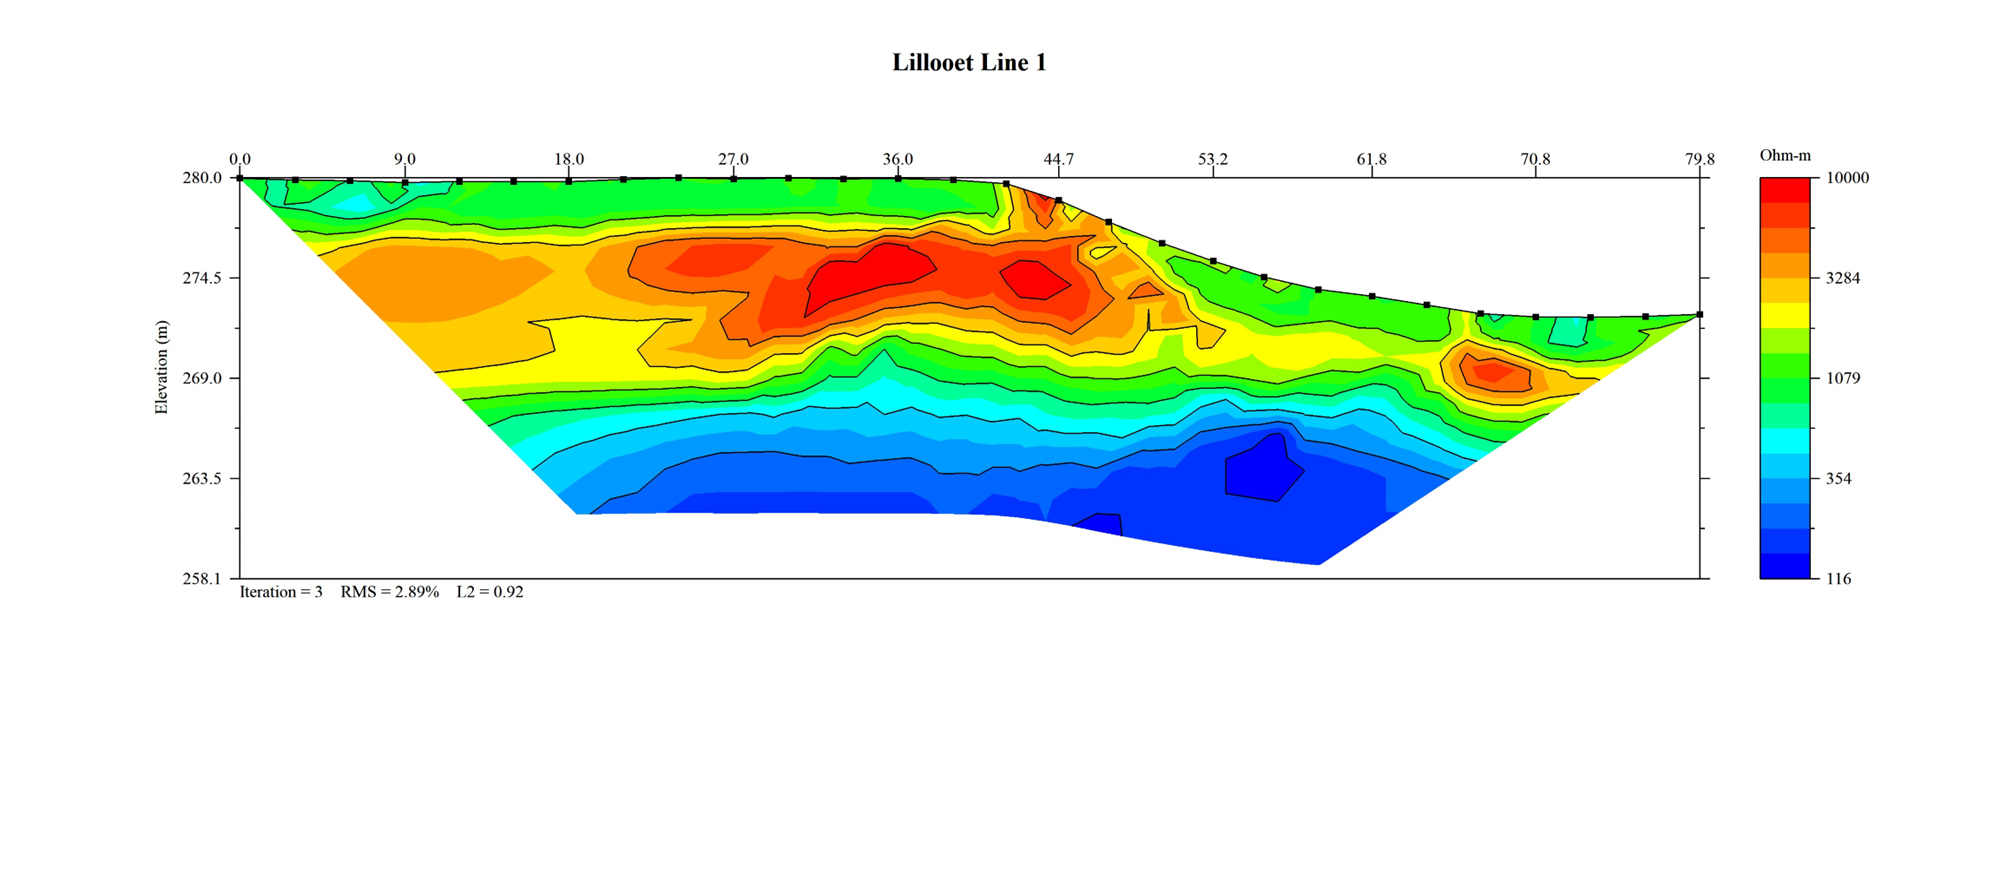

For now, this notebook loosely follows the SimPEG 2.5D DC Resistivity tutorial notebook (https://simpeg.xyz/user-tutorials/fwd-dcr-2d). 

## Import packages

In [1]:
# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import maps, data
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    generate_survey_from_abmn_locations
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

mpl.rcParams.update({"font.size": 14})  # default font size

write_output = False  # Optional

## Define topography 
...as a numpy.ndarray. 
This comes from field data.

Lillooet Line 1 (3 meter spacing), SW to NE.

In [2]:
topo_column_names = ['x','z']

In [3]:
topo_2d = pd.read_table('./fieldData/Terrain_Line1_3m_Aug26_2024.trn', names=topo_column_names, skiprows=3, delimiter=',', skipinitialspace=True)

In [4]:
topo_2d

,x,z
0,0.000000,279.927
1,3.019153,279.839
2,6.018717,279.798
3,9.015096,279.704
4,11.976175,279.760
5,14.957393,279.755
6,17.960852,279.750
7,20.954059,279.866
8,23.952542,279.964
9,26.958478,279.897


In [5]:
# Disregard this code block for now.
# topo_2d.iloc[:,0] += 219.78
# topo_2d

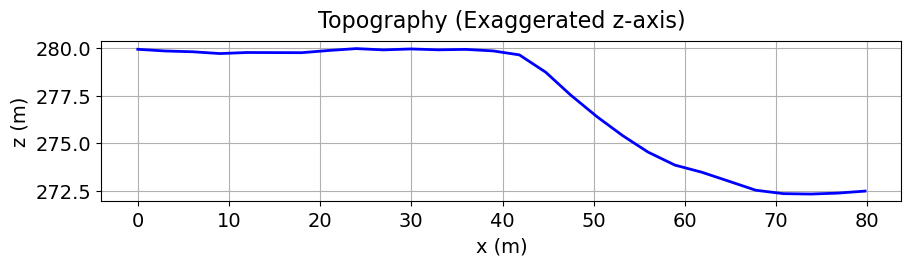

In [6]:
# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d.iloc[:,0], topo_2d.iloc[:,1], color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography (Exaggerated z-axis)", fontsize=16, pad=10)
plt.show(fig)

## Define the survey
Using simpeg.electromagnetics.static.utils.generate_survey_from_abmn_locations

In [7]:
# stg_column_names = ['datum', 'user', 'date', 'time', 'V/I', '%error', 'I', 'apparentRes',
#                 'commandFile',
#                 'Ax','Ay','Az',
#                 'Bx', 'By', 'Bz',
#                 'Mx', 'My', 'Mz',
#                 'Nx', 'Ny', 'Nz']

In [8]:
# locations = pd.read_table('./fieldData/3m_Texas_Creek_line1_2024_SWNE_HRF_Shifted_corrected.stg', header=0, names=stg_column_names, skiprows=2, delimiter=',', skipinitialspace=True)

In [9]:
# locations

In [10]:
# locations_a = locations.loc[:,'Ax']
# locations_b = locations.loc[:,'Bx']
# locations_m = locations.loc[:,'Mx']
# locations_n = locations.loc[:,'Nx']

In [11]:
# location_a = np.array(locations_a)
# location_b = np.array(locations_b)
# location_m = np.array(locations_m)
# location_n = np.array(locations_n)

# loc_a = np.c_(location_a, topo_2d[:,1])
# loc_b = np.c_(location_b, topo_2d[:,1])
# loc_m = np.c_(location_m, topo_2d[:,1])
# loc_n = np.c_(location_n, topo_2d[:,1])

^ Problem merging the two arrays, I assume do to python data type or array format discrepancies. MUST FIX!

In [12]:
# survey = generate_survey_from_abmn_locations(locations_a=location_a, locations_b= location_b, locations_m=location_m, locations_n=location_n, data_type='apparent_resistivity')

In [13]:
# generate_survey_from_abmn_locations?

### Create locations_a_indices, locations_b_indices, locations_m_indices, locations_n_indices
...from raw AGI MiniSting .stg raw data files, given the electrode spacing.

First extract dipole-dipole data from file: $a$ (dipole size), $na$ (distance between dipoles), $x_{mp}$ (x-coordinate for the midpoint between the two dipoles)



In [14]:
raw_data_column_names = [
    'datum', 'type', 'date', 'time', 'V/I', 'error in per mille', 'current [mA]', 'apparent resistivity [Ohm-m]', 'a', 'na', 'x_mp'
]
# raw_data_column_datatypes = {'a': float, 'na': float, 'x_mp': float}

In [15]:
raw_data = pd.read_table('./fieldData/3m_Texas_Creek_line1_2024.stg', sep=',', header=0, names = raw_data_column_names,
                         skiprows=3, skipfooter=1, skipinitialspace=True, engine='python',
                         usecols=[0,1,2,3,4,5,6,7,8,9,10])

In [16]:
raw_data

,datum,type,date,time,V/I,error in per mille,current [mA],apparent resistivity [Ohm-m],a,na,x_mp
0,2,RESIST,19970127,01:24:26,2971.600000,0,50,2.00,3.0,GR=500V,HV= 180V
1,3,RESIST,19970127,01:24:33,2191.800000,0,50,3.00,4.0,GR=500V,HV= 180V
2,4,RESIST,19970127,01:24:41,1738.800000,0,50,4.00,5.0,GR=500V,HV= 180V
3,5,RESIST,19970127,01:24:47,1362.700000,0,100,5.00,6.0,GR=500V,HV= 150V
4,6,RESIST,19970127,01:24:55,2043.500000,0,50,6.00,7.0,GR=500V,HV= 180V
...,...,...,...,...,...,...,...,...,...,...,...
236,238,DIP-DIP,19970127,02:36:33,0.043859,9,20,260.42,9.0,4.5000E+01,4.9500E+01
237,239,DIP-DIP,19970127,02:36:49,0.052734,5,50,500.98,9.0,5.4000E+01,3.6000E+01
238,240,DIP-DIP,19970127,02:37:04,0.047357,2,100,449.90,9.0,5.4000E+01,3.9000E+01
239,241,DIP-DIP,19970127,02:37:18,0.037273,2,100,354.10,9.0,5.4000E+01,4.2000E+01


In [17]:
# Remove rows with type != DIP-DIP
raw_data = raw_data[raw_data.loc[:,'type'].str.contains("DIP-DIP", na=False)]
raw_data

,datum,type,date,time,V/I,error in per mille,current [mA],apparent resistivity [Ohm-m],a,na,x_mp
26,28,DIP-DIP,19970127,01:43:50,13.619000,0,100,770.16,3.0,3.0000E+00,4.5000E+00
27,29,DIP-DIP,19970127,01:44:03,14.129000,0,100,798.99,3.0,3.0000E+00,7.5000E+00
28,30,DIP-DIP,19970127,01:44:16,16.094000,0,100,910.07,3.0,3.0000E+00,1.0500E+01
29,31,DIP-DIP,19970127,01:44:31,15.828000,0,50,895.05,3.0,3.0000E+00,1.3500E+01
30,32,DIP-DIP,19970127,01:44:44,15.920000,0,100,900.24,3.0,3.0000E+00,1.6500E+01
...,...,...,...,...,...,...,...,...,...,...,...
236,238,DIP-DIP,19970127,02:36:33,0.043859,9,20,260.42,9.0,4.5000E+01,4.9500E+01
237,239,DIP-DIP,19970127,02:36:49,0.052734,5,50,500.98,9.0,5.4000E+01,3.6000E+01
238,240,DIP-DIP,19970127,02:37:04,0.047357,2,100,449.90,9.0,5.4000E+01,3.9000E+01
239,241,DIP-DIP,19970127,02:37:18,0.037273,2,100,354.10,9.0,5.4000E+01,4.2000E+01


In [18]:
# Set datatypes of a, na, and x_mp to float so that we can do math on them
raw_data.loc[:,'na'] = raw_data.loc[:,'na'].astype(float)
raw_data.loc[:,'x_mp'] = raw_data.loc[:,'x_mp'].astype(float)
raw_data

,datum,type,date,time,V/I,error in per mille,current [mA],apparent resistivity [Ohm-m],a,na,x_mp
26,28,DIP-DIP,19970127,01:43:50,13.619000,0,100,770.16,3.0,3.0,4.5
27,29,DIP-DIP,19970127,01:44:03,14.129000,0,100,798.99,3.0,3.0,7.5
28,30,DIP-DIP,19970127,01:44:16,16.094000,0,100,910.07,3.0,3.0,10.5
29,31,DIP-DIP,19970127,01:44:31,15.828000,0,50,895.05,3.0,3.0,13.5
30,32,DIP-DIP,19970127,01:44:44,15.920000,0,100,900.24,3.0,3.0,16.5
...,...,...,...,...,...,...,...,...,...,...,...
236,238,DIP-DIP,19970127,02:36:33,0.043859,9,20,260.42,9.0,45.0,49.5
237,239,DIP-DIP,19970127,02:36:49,0.052734,5,50,500.98,9.0,54.0,36.0
238,240,DIP-DIP,19970127,02:37:04,0.047357,2,100,449.90,9.0,54.0,39.0
239,241,DIP-DIP,19970127,02:37:18,0.037273,2,100,354.10,9.0,54.0,42.0


Given electrode spacing $s$,

$$i = \frac{x_{mp}}{s} - \frac{\frac{na}{s}}{2}$$

$$j = i - \frac{a}{s}$$

$$k = \frac{x_{mp}}{s} + \frac{\frac{na}{s}}{2}$$

$$l = k + \frac{a}{s}$$

where $i$ is the A index, $j$ is the B index, $k$ is the M index, and $l$ is the N index.

In [19]:
s = 3.0

In [20]:
apparent_resistivities = raw_data.loc[:,'apparent resistivity [Ohm-m]']
# apparent_resistivities

In [21]:
locations_a_indices = (raw_data.loc[:,'x_mp'] / s) - (raw_data.loc[:,'na'] / s)/2
locations_a_indices = locations_a_indices.astype(int)
# locations_a_indices

In [22]:
locations_b_indices = locations_a_indices - (raw_data.loc[:,'a']/s)
locations_b_indices = locations_b_indices.astype(int)
# locations_b_indices

In [23]:
locations_m_indices = (raw_data.loc[:,'x_mp']/ s) + (raw_data.loc[:,'na'] / s) / 2
locations_m_indices = locations_m_indices.astype(int)
# locations_m_indices

In [24]:
locations_n_indices = locations_m_indices + (raw_data.loc[:,'a'] / s)
locations_n_indices = locations_n_indices.astype(int)
# locations_n_indices

In [25]:
n = len(apparent_resistivities)
n

215

In [26]:
# Initialize locations arrays
locations_a = np.zeros((n,2))
locations_b = np.zeros((n,2))
locations_m = np.zeros((n,2))
locations_n = np.zeros((n,2))

In [27]:
for i in range(len(apparent_resistivities)):
    locations_a[i] = [topo_2d.loc[np.array(locations_a_indices)[i],'x'], topo_2d.loc[np.array(locations_a_indices)[i],'z']]
    locations_b[i] = [topo_2d.loc[np.array(locations_b_indices)[i],'x'], topo_2d.loc[np.array(locations_b_indices)[i],'z']]
    locations_m[i] = [topo_2d.loc[np.array(locations_m_indices)[i],'x'], topo_2d.loc[np.array(locations_m_indices)[i],'z']]
    locations_n[i] = [topo_2d.loc[np.array(locations_n_indices)[i],'x'], topo_2d.loc[np.array(locations_n_indices)[i],'z']]

In [28]:
survey = generate_survey_from_abmn_locations(locations_a=locations_a, locations_b=locations_b,
                                             locations_m=locations_m, locations_n=locations_n,
                                             data_type='apparent_resistivity')
survey


C:\Users\raulm\AppData\Local\Temp\ipykernel_17392\1012465588.py:1: UserWarning: Ordering of ABMN locations changed when generating survey. Associated data vectors will need sorting. Set output_sorting to True for sorting indices.
  survey = generate_survey_from_abmn_locations(locations_a=locations_a, locations_b=locations_b,


Survey(#sources: 52; #data: 215)

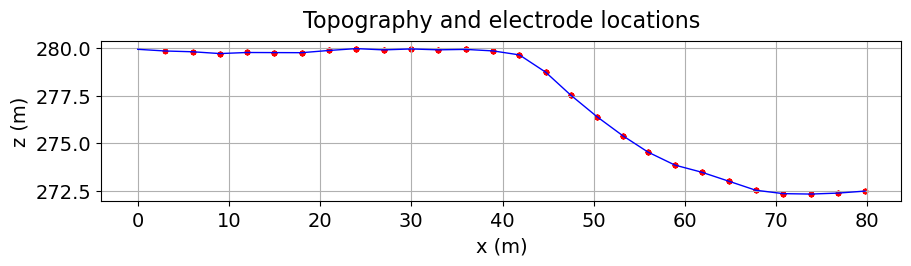

In [29]:
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d['x'], topo_2d['z'], color="b", linewidth=1)
ax.scatter(locations_a[:,0], locations_a[:,1], 8, "r")
ax.scatter(locations_n[:,0], locations_n[:,1], 8, "r")
# ax.set_xlim([x_topo.min(), x_topo.max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and electrode locations", fontsize=16, pad=10)
plt.show(fig)

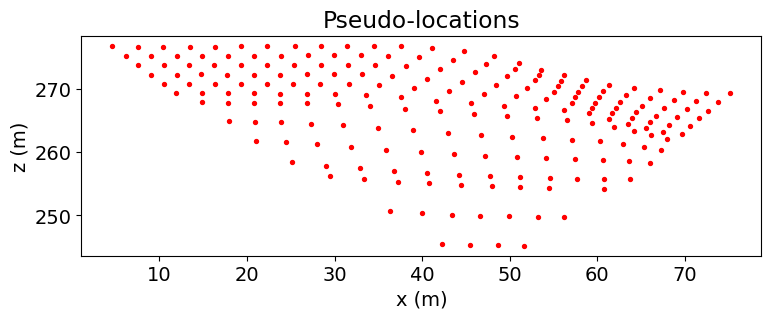

In [30]:
pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
ax.set_title("Pseudo-locations")
plt.show()